In [1]:
# Add project root to PYTHONPATH
import sys; sys.path.append("../")

In [2]:
from wavenet.detection import KeywordDetector
from threading import Thread, Event
import matplotlib.pyplot as plt
from time import sleep
import numpy as np
import pyaudio

In [11]:
def prediction_loop(detector, stop):
    print("Prediction thread started")
    fig = plt.figure(figsize=(10, 5))
    plt.title("Live detection")
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    history = [(0, False)] * 100
    while not stop.is_set():
        res = detector.predict()
        if res is not None:
            ax.clear()
            history.append(res)
            history = history[1:]
            levels = [x[0] for x in history]
            ax.plot(levels, c="b")
            for i, (_, trigger) in enumerate(history):
                if trigger:
                    ax.axvline(x=i, c="r")
            ax.set_ylim((0, 1))
            fig.canvas.draw()
        sleep(0.001)


def audio_loop(detector, stream, stop):
    print("Audio thread started")
    while not stop.is_set():
        chunk = stream.read(detector.config.fft_window_step)
        chunk = np.frombuffer(chunk, dtype="float32")
        detector.push_audio(chunk)
    stream.stop_stream()
    stream.close()


def run_detection(detector):
    audio = pyaudio.PyAudio()
    stream = audio.open(
        format=pyaudio.paFloat32,
        rate=detector.config.sample_rate,
        frames_per_buffer=detector.config.fft_window_step,
        channels=1,
        input=True,
    )

    stop = Event()
    prediction_thread = Thread(
        target=prediction_loop,
        args=(detector, stop),
    )
    audio_thread = Thread(
        target=audio_loop,
        args=(detector, stream, stop),
    )
    prediction_thread.start()
    audio_thread.start()

    try: input("PRESS ENTER TO TERMINATE: ")
    except KeyboardInterrupt: pass
    print("Terminating...", end=" ", flush=True)
    stop.set()
    prediction_thread.join()
    audio_thread.join()
    print("DONE")

Prediction thread started
Audio thread started


<IPython.core.display.Javascript object>


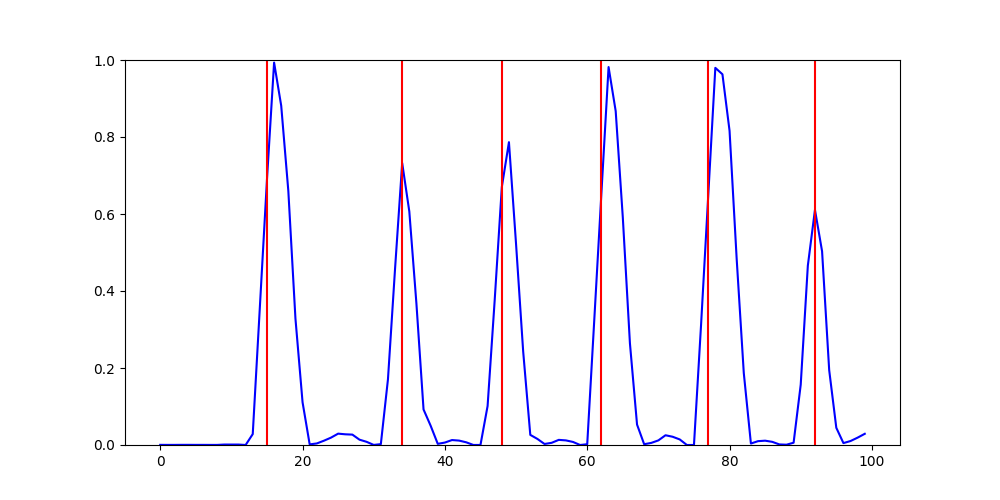

<ipython-input-11-40b1c0d9b0a2>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


PRESS ENTER TO TERMINATE: 
Terminating... DONE


In [12]:
%matplotlib notebook
detector = KeywordDetector(
    checkpoint="../checkpoints/v1.final.pt",
    threshold=0.6,
    smoothing=3,
    timeout=1.0,
)
run_detection(detector)